# Overview
This code is written in Colab.
Before train model, you have to store Dataset to google drive.

Or you can change path and directory variable to your setting.

# Step1. Connect to Google Drive and Development Setting

- Dependencies
```
pandas version= 1.3.5
numpy version= 1.22.4
tensorflow version= 2.2.0
PIL version= 7.1.2
matplotlib= 3.5.3
```
- Dataset
  - First you must preprocess dataset and then run this code.  
  - Plz make your dataset structure like below that.  
  Or if you want custom, you have to change several code.  
  Dataset folder structure.
  ```
    GooglDrive
    └─ test
        └─ {Dataset_name}.zip
  ```

In [1]:
# Connect to the Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Install tensorflow 2.2.0.
!pip install -U --pre tensorflow=='2.2.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.6/454.6 KB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 103.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 19.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uni

In [3]:
# These libraries are freely to version, you can use default  version in colab (except for TensorFlow).
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
from queue import Queue
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from IPython.display import display
import PIL

In [11]:
print(f'pandas version= {pd.__version__}')
print(f'numpy version= {np.__version__}')
print(f'tensorflow version= {tf.__version__}')
print(f'PIL version= {PIL.__version__}')

pandas version= 1.3.5
numpy version= 1.22.4
tensorflow version= 2.2.0
PIL version= 7.1.2


**Workspace folder is main folder that is stored your trained model and dataset**

In [4]:
!mkdir /content/workspace

# Step 2. Prepare dataset for training

**Download preprocessed dataset for training**


In [5]:
!cp -r /content/gdrive/MyDrive/test/Resized_48x48_grayscale.zip /content/workspace

In [6]:
!unzip /content/workspace/Resized_48x48_grayscale.zip -d /content/workspace/

Archive:  /content/workspace/Resized_48x48_grayscale.zip
   creating: /content/workspace/Resized_48x48_grayscale/
   creating: /content/workspace/Resized_48x48_grayscale/Dataset/
   creating: /content/workspace/Resized_48x48_grayscale/Dataset/train/
   creating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/
  inflating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/foto00088.png  
  inflating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/foto00117.png  
  inflating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/foto00204.png  
  inflating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/foto00233.png  
  inflating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/foto00262.png  
  inflating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/foto00291.png  
  inflating: /content/workspace/Resized_48x48_grayscale/Dataset/train/data0/foto00320.png  
  inflating: /content/workspa

**Set path variables for training**

  **You can set your directory and path what you want.**

  *   But if you use your custom directory (not Google drive). 
  *   You have to chnage dir, path varaibles.



In [8]:
import os

# workspace is stored everything you need to traing model (dataset, model, configfile).
WORKSPACE_PATH = '/content/workspace'

# dataset directory name
DATASET_DIR = 'Resized_48x48_grayscale'

# DATASET pathes
DATASET_PAHT = '/content/gdrive/MyDrive/test'
TRAIN_DATASET_PATH = os.path.join(WORKSPACE_PATH, DATASET_DIR, 'Dataset/train')
TEST_DATASET_PATH = os.path.join(WORKSPACE_PATH, DATASET_DIR, 'Dataset/train')

- get_images()
```
This function returns image list for training model or predictig.
Return value is feeded to model.
```

In [212]:

import cv2

def get_images(path):
  images = []
  for filename in os.listdir(path):
    # img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_GRAYSCALE) 
    img = cv2.imread(os.path.join(path, filename), cv2.IMREAD_UNCHANGED)
    img = np.expand_dims(img, axis=-1)
    images.append(img)
  return np.array(images)


- Set train data for training and testing model





In [99]:
training_dataset_images_path = TRAIN_DATASET_PATH + '/data0'
testing_dataset_images_path = TEST_DATASET_PATH + '/data2'

In [100]:
# Information about bounding box location, image shape and class
# Read annotation file and wrie to CSV obejct
boxes_df = pd.read_csv('/content/workspace/Resized_48x48_grayscale/Annotations/train/annotation0/0.csv')
boxes_df.head()

,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,foto00088.png,48,48,drone,18.6000,17.400000,27.6375,27.400000
1,1,foto00117.png,48,48,drone,19.4625,17.200000,27.7500,27.600000
2,2,foto00204.png,48,48,drone,22.3875,17.933333,25.7250,22.733333
3,3,foto00233.png,48,48,drone,23.0250,19.533333,25.8750,23.400000
4,4,foto00262.png,48,48,drone,16.2750,15.066667,27.3000,31.466667


In [101]:
# Get bounding box informatino (real value of preidcted value)
print(f'training_dataset_images_path ={training_dataset_images_path}\n')
train_x = get_images(training_dataset_images_path)

# print(f'train_x.shape ={train_x.shape}')
train_y = (boxes_df[['xmin', 'ymin', 'xmax','ymax']]).to_numpy()

print(f'[train_y]\n{train_y}')


training_dataset_images_path =/content/workspace/Resized_48x48_grayscale/Dataset/train/data0

[train_y]
[[18.6        17.4        27.6375     27.4       ]
 [19.4625     17.2        27.75       27.6       ]
 [22.3875     17.93333333 25.725      22.73333333]
 ...
 [ 6.9         2.66666667 46.35       37.06666667]
 [ 1.85454545  2.7        46.14545455 35.1       ]
 [ 3.609375   27.63076923 26.671875   42.03076923]]


# Step3. Construct the model

In [204]:
import sys
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import unit_norm

in_shape=(48, 48, 1)
out_shape = 4

model = tf.keras.Sequential()
    
#filter size is 3*3*volume; number of filters = 32; activation=relu;  (convolution layer)
model.add(Conv2D(2, (3, 3), activation='relu', padding='same', input_shape=in_shape, kernel_initializer='he_normal', kernel_constraint=unit_norm(), kernel_regularizer=regularizers.l2(l=0.001))) 
model.add(Conv2D(4, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_constraint=unit_norm(), kernel_regularizer=regularizers.l2(l=0.001))) 
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((6, 6)))

#fully connected layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.1))
# model.add(Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(out_shape))
 
# compile model
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.mse])


In [187]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 48, 48, 2)         20        
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 48, 48, 4)         76        
_________________________________________________________________
batch_normalization_35 (Batc (None, 48, 48, 4)         16        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 8, 8, 4)           0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 256)               0         
_________________________________________________________________
dropout_53 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 2)               

### Step3. Training the model

In [188]:
history = model.fit(train_x, train_y, epochs=500)

Epoch 1/500
13/13 [==============================] - 0s 25ms/step - loss: 768.6785 - mean_squared_error: 768.6497
Epoch 2/500
13/13 [==============================] - 0s 24ms/step - loss: 768.6872 - mean_squared_error: 768.6570
Epoch 3/500
13/13 [==============================] - 0s 23ms/step - loss: 768.4501 - mean_squared_error: 768.4201
Epoch 4/500
13/13 [==============================] - 0s 24ms/step - loss: 768.3961 - mean_squared_error: 768.3660
Epoch 5/500
13/13 [==============================] - 0s 24ms/step - loss: 768.4197 - mean_squared_error: 768.3896
Epoch 6/500
13/13 [==============================] - 0s 24ms/step - loss: 768.3035 - mean_squared_error: 768.2736
Epoch 7/500
13/13 [==============================] - 0s 24ms/step - loss: 768.3690 - mean_squared_error: 768.3390
Epoch 8/500
13/13 [==============================] - 0s 23ms/step - loss: 768.1458 - mean_squared_error: 768.1157
Epoch 9/500
13/13 [==============================] - 0s 24ms/step - loss: 768.0068 - mea

# Step4. Inference

In [190]:
print(f'testing_dataset_images_path ={testing_dataset_images_path}\n')
test_x = get_images(testing_dataset_images_path)

print(f'test_x.shape ={test_x.shape}')

test_df = pd.read_csv('/content/workspace/Resized_48x48_grayscale/Annotations/train/annotation2/2.csv')

test_df.head()

testing_dataset_images_path =/content/workspace/Resized_48x48_grayscale/Dataset/train/data2

test_x.shape =(295, 48, 48, 1)


,Unnamed: 0,filename,width,height,class,xmin,ymin,xmax,ymax
0,0,pic_664.jpg,48,48,drone,2.208000,12.960000,45.024000,34.656000
1,1,pic_665.jpg,48,48,drone,0.137143,9.462857,48.000000,31.680000
2,2,pic_666.jpg,48,48,drone,0.510638,0.834783,45.242553,48.000000
3,3,pic_667.jpg,48,48,drone,0.320000,6.000000,45.440000,37.680000
4,4,pic_668.jpg,48,48,drone,0.576000,0.170819,46.560000,40.825623


In [191]:
# You can inference by using predict() funciton
new_y = model.predict(test_x)

In [192]:
# convert predicted data to CSV
test_df_pred = pd.DataFrame(new_y, columns=['pred_xmin', 'pred_ymin', 'pred_xmax', 'pred_ymax']).reset_index()
test_df_pred['imageid'] = test_df['filename']
test_df_pred.to_csv('./mask_csv.csv',index=False)

# Step5. Visualize inference result


*   Visualize predicted value (coordinates of bouding box).
*   We ues matplotlib to visualize bounding box. 





3.5.3
mkdir: cannot create directory ‘/content/masks’: File exists
/content/workspace/Resized_48x48_grayscale/Dataset/train/data2


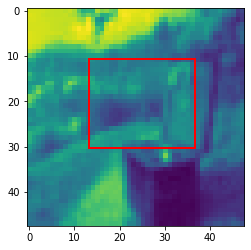

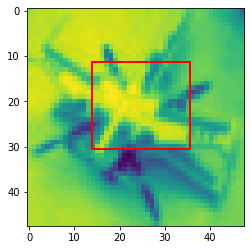

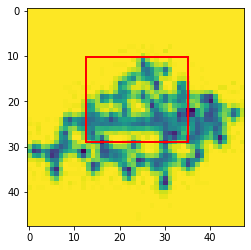

295


In [210]:
# Visualize predicted value (coordinates of bouding box).
# we will ues matplotlib to visualize bounding box.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

print(matplotlib.__version__)

!mkdir /content/masks
save_maske_images_dir = '/content/masks'

print(testing_dataset_images_path)

i = 0

# writing the mask into the file
for filename in os.listdir(testing_dataset_images_path):
  if i % 100 == 0:
      im = Image.open(os.path.join(testing_dataset_images_path,filename))
      
      #Create figure and axes
      fig, ax = plt.subplots()
      
      # Display the image
      ax.imshow(im)
      
      bbox = (test_df.loc[test_df.filename == filename])
      bbox = bbox['Unnamed: 0']

      info = new_y[bbox][0]

      width = info[2] - info[0]
      height = info[3] - info[1]

      # 
      if width < 0 or height < 0 or info[0] < 0 or info[1] < 0 or info[2] < 0 or info[3] < 0:
        pass

      rect = patches.Rectangle((info[0],info[1]), width, height, linewidth=2, edgecolor='r', facecolor='none')

      # # Add the patch to the Axes
      ax.add_patch(rect)
      plt.savefig(save_maske_images_dir+'/'+filename)
      
      plt.show()
  i += 1
print(i)

# Step6. Convert TensorFlow Model to TensorFlow Lite model

We can use tf.lite.TFLiteConverter() object. <br>
Our model is tf.keras, we use tf.lite.TFLiteConverter.from_keras_model object to convert TF model. <br>

By using TF converter, you can compress model size.

In [194]:
# This codes is Quantization option.
# Before covert TFL model to C style code you can datatype quantization.
# You can choose several option to compress model detection

# [Just convert TF model to TFL model ]
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# [FLoat 32bit to Float 16bit, it compress model size by half]
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# tflite_model = converter.convert()

# # [Convert using dynamic range quantization] 
# It compress model size to 1/4
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_model = converter.convert()


# [8bit]
# It compress model size to 1/4
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# # converter.representative_dataset = representative_dataset
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8
# tflite_quant_model = converter.convert()

# [Convert using float fallback quantization]
# it compress model size by half
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.target_spec.supported_ops = [
# tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
# ]
# converter._experimental_lower_tensor_list_ops = True
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# tflite_model = converter.convert()

In [211]:
# You can check converted TensorFlow lite model information
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors() 
interpreter.get_input_details()

[{'name': 'conv2d_70_input',
  'index': 0,
  'shape': array([ 1, 48, 48,  1], dtype=int32),
  'shape_signature': array([ 1, 48, 48,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

# Step.7 Convert TensorFlow Lite model to C style code


xxd is a command-line tool that is used to create a hex dump of a given file or standard input. It can also convert a hex dump back to its original binary form. <br>

After convert our model to C binary form. We can use this in C code. It means we can use converted model in Arduino IDE.

In [203]:
# Save the model to tensorflow lite file
with open('custom_model_48x48_gray.tflite', 'wb') as f:
  f.write(tflite_model)

# Step8. Just copy and paste this output to our arduino soure file (**drone_detect_model_data.cpp**).

In [196]:
# Install xxd if it is not available

# !sudo apt-get update
# !sudo apt-get install xxd
     
# Save the file as a C source file

!xxd -i custom_model_48x48_gray.tflite > custom_model_48x48_gray.cc
# Print the source file
!cat custom_model_48x48_gray.cc

unsigned char custom_model_48x48_gray_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00, 0x06, 0x00, 0x00, 0x00,
  0xbc, 0x06, 0x00, 0x00, 0xe8, 0x04, 0x00, 0x00, 0x34, 0x04, 0x00, 0x00,
  0x90, 0x03, 0x00, 0x00, 0xd4, 0x02, 0x00, 0x00, 0x30, 0x02, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0xd4, 0x00, 0x00, 0x00, 0x16, 0x00, 0x00, 0x00,
  0xb4, 0x15, 0x00, 0x00, 0xb0, 0x15, 0x00, 0x00, 0xec, 0x14, 0x00, 0x00,
  0x70, 0x14, 0x00, 0x00, 0x04, 0x14, 0x00, 0x00, 0x90, 0x13, 0x00, 0x00,
  0x20, 0x13, 0x00, 0x00, 0xa4, 0x12, 0x00, 0x00, 0x28, 0x12, 0x00, 0x00,
  0xd0, 0x09, 0x00, 0x00, 0x58, 0x09, 0x00, 0x00, 0xb0, 0x08, 0x00, 0x00,
  0x30, 0x07, 0x00, 0x00, 0x80, 0x15, 0x00, 0x00, 0x7c, 0x15,